## Background & Context

There is a huge demand for used cars in the Indian Market today. As sales of new cars have slowed down in the recent past, the pre-owned car market has continued to grow over the past years and is larger than the new car market now. Cars4U is a budding tech start-up that aims to find footholes in this market.

In 2018-19, while new car sales were recorded at 3.6 million units, around 4 million second-hand cars were bought and sold. There is a slowdown in new car sales and that could mean that the demand is shifting towards the pre-owned market. In fact, some car sellers replace their old cars with pre-owned cars instead of buying new ones. Unlike new cars, where price and supply are fairly deterministic and managed by OEMs (Original Equipment Manufacturer / except for dealership level discounts which come into play only in the last stage of the customer journey), used cars are very different beasts with huge uncertainty in both pricing and supply. Keeping this in mind, the pricing scheme of these used cars becomes important in order to grow in the market.

As a senior data scientist at Cars4U, you have to come up with a pricing model that can effectively predict the price of used cars and can help the business in devising profitable strategies using differential pricing. For example, if the business knows the market price, it will never sell anything below it. 

## Problem Statement:
We would like to understand the factors that influence the price of a used car and build a model that predicts the prices of used cars using those factors. Once the model is built - we would like to assess it for its accuracy and tweak the model until it gives us satisfactory performance. When the model is built, we would like to answer the following questions.

We would also like to give a few strategies for the business on optimizing their profit based on the data elements availabel to us. For instance - does it make sense to focus on a particular market/city or brand that will maximize profit or minimize loss. 

## Data Import and Analysis

### Import libraries

In [754]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# To enable plotting graphs in Jupyter notebook
%matplotlib inline
import re as re
import warnings
warnings.filterwarnings("ignore")

# To create linear regression model
from sklearn.linear_model import LinearRegression

# To check model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Load  data from the CSV file

In [755]:
# Load the data set and save it in a pandas dataframe
used_cars = pd.read_csv("used_cars_data.csv") 

### Check cloumns and column types

In [756]:
# Let's check the nature of the data set
used_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No.              7253 non-null   int64  
 1   Name               7253 non-null   object 
 2   Location           7253 non-null   object 
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7251 non-null   object 
 9   Engine             7207 non-null   object 
 10  Power              7207 non-null   object 
 11  Seats              7200 non-null   float64
 12  New_Price          1006 non-null   object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 793.4+ KB


#### Observations based on data import
1. There are 7253 rows (i.e. information on 7253 used cars) and 14 columns (i.e. 14 attributes for each car. 
2. Critical categorical variables like Fuel_type, Transmission and Owner_Type are captured as objects. Such variables tend to have a few categores and hence should be converted as categorical variables later in the analysis 
3. New prices are available only for a small percentage of the data set. Since we dont have insight in to variables that affect new prices - it is hard to extrapolate missing values with a median or a average. 
4. Critical numerical variables like Mileage, Engine and Power are captured as objects - we need to convert them in to numerical values in our analysis
5. Price is missing a significant percentage of data. Since Price happens to be the independent variable - it may be hard to predict extrapolate it. 
6. It would make logical sense that the brand and model of a car will impact the price. But adding model will potentially complicate the model. We will consider extracting the brand information from the data for further analysis

### Let's convert critical numerical variables from object type to numerical

In [757]:
#Function to convert string to float - for power and mileage
def text_to_float(text):
    str_text = str(text)
    num = re.findall(r'[0-9]+.[0-9]+',str_text)
    return pd.to_numeric("".join(num), downcast='float')

# Function to convert string to int - for engine 
def text_to_int(text):
    str_text = str(text)
    num = re.findall(r'[0-9]+',str_text)
    return pd.to_numeric("".join(num), downcast='unsigned')

def process_new_price(text):
    str_text = str(text)
    num = re.findall(r'[0-9]+.[0-9]*',str_text)
    denomination = re.findall(r'[A-Z][a-z]+',str_text)
    denomination_str = "".join(denomination)
    if (denomination_str == "Cr"):
        return pd.to_numeric("".join(num), downcast='float')*100
    else:
        return pd.to_numeric("".join(num), downcast='float')

# Convert Mileage, Engine and Power to numerical data type
used_cars['Mileage_Numeric'] = used_cars.apply(lambda x: text_to_float(x['Mileage']),axis=1)
used_cars['Engine_Numeric'] = used_cars.apply(lambda x: text_to_int(x['Engine']),axis=1)
used_cars['Power_Numeric'] = used_cars.apply(lambda x: text_to_float(x['Power']),axis=1)
used_cars['New_Price_Numeric'] = used_cars.apply(lambda x: process_new_price (x['New_Price']),axis=1)


### Let's convert critical categorial variables from object type to numerical

In [758]:
# Converting object type to category columns
used_cars['Location'] = pd.Categorical(used_cars.Location)
used_cars['Fuel_Type'] = pd.Categorical(used_cars.Fuel_Type)
used_cars['Transmission'] = pd.Categorical(used_cars.Transmission)
used_cars['Owner_Type'] = pd.Categorical(used_cars.Owner_Type)

### Let's extract Brand information and store in a new variable called - 'Brand'

In [759]:
# It will be intertesting to extract the make of the vehicle and treat is as a categorical variable

# Function to exract make   
def extract_brand(text):
    str_list = text.split()
    return "".join(str_list[0])

used_cars['Brand'] = used_cars.apply(lambda x: extract_brand(x['Name']),axis=1)

# Make Brand a categorical variable
used_cars['Brand'] = pd.Categorical(used_cars.Brand)

# List unique brand values
used_cars.Brand.unique()

['Maruti', 'Hyundai', 'Honda', 'Audi', 'Nissan', ..., 'Force', 'Bentley', 'Lamborghini', 'Hindustan', 'OpelCorsa']
Length: 33
Categories (33, object): ['Maruti', 'Hyundai', 'Honda', 'Audi', ..., 'Bentley', 'Lamborghini', 'Hindustan', 'OpelCorsa']

### Normalizing Price
Price is listed in lakhs, which is an order of 100,000. This results in a price scale which can be in the tens and hence makes it hard to visualize trends and patterns. Let's convert it to the unit of currency in Rs by multiplying by 100,000

In [760]:
used_cars['Price'] = used_cars['Price'] * 100000
used_cars.head()

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Mileage_Numeric,Engine_Numeric,Power_Numeric,New_Price_Numeric,Brand
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,175000.0,26.600000,998.0,58.160000,NaN,Maruti
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,1250000.0,19.670000,1582.0,126.199997,NaN,Hyundai
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,450000.0,18.200001,1199.0,88.699997,8.61,Honda
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,600000.0,20.770000,1248.0,88.760002,NaN,Maruti
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,1774000.0,15.200000,1968.0,140.800003,NaN,Audi


### Look for missing values

In [761]:
used_cars.isna().sum()

S.No.                   0
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                  46
Seats                  53
New_Price            6247
Price                1234
Mileage_Numeric         2
Engine_Numeric         46
Power_Numeric        1327
New_Price_Numeric    6247
Brand                   0
dtype: int64

1. There are quite a few values of the dependent variable 'New_Price' that are missing (6247) - which represents over 86% of the data set. There is no reasoable way to assume a meaningful median. Therefore let's drop the column from the model. 
2. There are quite a few rows of the dependent variable missing (about 1234 which represents about 17% of the data set). There are two ways to solve this. Either we drop the missing rows or we use the missing rows as test data. 

### Fix missing values

In [762]:
used_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   S.No.              7253 non-null   int64   
 1   Name               7253 non-null   object  
 2   Location           7253 non-null   category
 3   Year               7253 non-null   int64   
 4   Kilometers_Driven  7253 non-null   int64   
 5   Fuel_Type          7253 non-null   category
 6   Transmission       7253 non-null   category
 7   Owner_Type         7253 non-null   category
 8   Mileage            7251 non-null   object  
 9   Engine             7207 non-null   object  
 10  Power              7207 non-null   object  
 11  Seats              7200 non-null   float64 
 12  New_Price          1006 non-null   object  
 13  Price              6019 non-null   float64 
 14  Mileage_Numeric    7251 non-null   float64 
 15  Engine_Numeric     7207 non-null   float64 
 16  Power_

In [763]:
# we will replace missing values in every column with its medain
medianFiller = lambda x: x.fillna(x.median())

used_cars['Mileage_Numeric'] = used_cars['Mileage_Numeric'].fillna(used_cars['Mileage_Numeric'].median())
used_cars['Engine_Numeric'] = used_cars['Engine_Numeric'].fillna(used_cars['Engine_Numeric'].median())
used_cars['Power_Numeric'] = used_cars['Power_Numeric'].fillna(used_cars['Power_Numeric'].median())
used_cars['Seats'] = used_cars['Seats'].fillna(used_cars['Seats'].median())
used_cars.dropna(how='any', subset=['Price'], inplace=True)
used_cars.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6019 entries, 0 to 6018
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   S.No.              6019 non-null   int64   
 1   Name               6019 non-null   object  
 2   Location           6019 non-null   category
 3   Year               6019 non-null   int64   
 4   Kilometers_Driven  6019 non-null   int64   
 5   Fuel_Type          6019 non-null   category
 6   Transmission       6019 non-null   category
 7   Owner_Type         6019 non-null   category
 8   Mileage            6017 non-null   object  
 9   Engine             5983 non-null   object  
 10  Power              5983 non-null   object  
 11  Seats              6019 non-null   float64 
 12  New_Price          824 non-null    object  
 13  Price              6019 non-null   float64 
 14  Mileage_Numeric    6019 non-null   float64 
 15  Engine_Numeric     6019 non-null   float64 
 16  Power_

### Observations  
From the output above - we can see the missing values are calculated for all numeric types

In [764]:
used_cars.describe()

,S.No.,Year,Kilometers_Driven,Seats,Price,Mileage_Numeric,Engine_Numeric,Power_Numeric,New_Price_Numeric
count,6019.000000,6019.000000,6.019000e+03,6019.000000,6.019000e+03,6019.000000,6019.000000,6019.000000,824.000000
mean,3009.000000,2013.358199,5.873838e+04,5.276790,9.479468e+05,18.134969,1620.509221,117.728745,23.075655
std,1737.679967,3.269742,9.126884e+04,0.806346,1.118792e+06,4.581528,599.635458,50.669981,26.182412
min,0.000000,1998.000000,1.710000e+02,0.000000,4.400000e+04,0.000000,72.000000,34.200001,3.910000
25%,1504.500000,2011.000000,3.400000e+04,5.000000,3.500000e+05,15.170000,1198.000000,86.800003,7.977500
50%,3009.000000,2014.000000,5.300000e+04,5.000000,5.640000e+05,18.160000,1493.000000,103.599998,11.670000
75%,4513.500000,2016.000000,7.300000e+04,5.000000,9.950000e+05,21.100000,1969.000000,138.029999,26.559999
max,6018.000000,2019.000000,6.500000e+06,10.000000,1.600000e+07,33.540001,5998.000000,560.000000,229.999995


### Univariate analysis of numerical variables - histograms

['Kilometers_Driven', 'Seats', 'Price', 'Mileage_Numeric', 'Engine_Numeric', 'Power_Numeric']


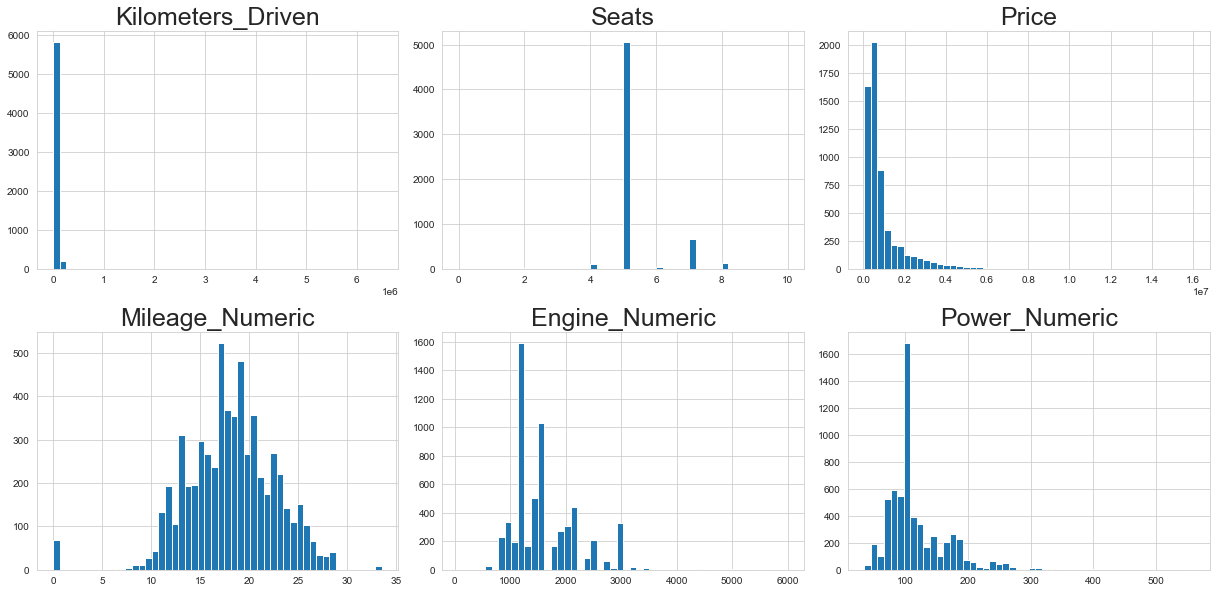

In [765]:
# lets plot histogram of all plots
numerical_columns = used_cars.select_dtypes(include=np.number).columns.tolist()


# Let's remove Year as it is a temporal variable
numerical_columns.remove('Year')

#Let's remove S.No. as it ir nto relevant to the model
numerical_columns.remove('S.No.')

# Let's remove New_Price from the analysis - since it has way too many missing values
numerical_columns.remove('New_Price_Numeric')

print(numerical_columns)
plt.figure(figsize=(17,75))

for i in range(len(numerical_columns)):
    plt.subplot(18,3,i+1)
    plt.hist(used_cars[numerical_columns[i]], bins=50)
    plt.tight_layout()
    plt.title(numerical_columns[i],fontsize=25)
    
plt.show()

#### Obsevations from Univariate analysis
1. Kilometers_Driven appears to be very non linear. A log transformation will be helpful during regression  
2. Seats is not very normally distributed - which is understandable as most cars tend to have 5 seats.   
3. Price is heavily right skewed with some extreme values. Price is also a good candidate for linear transformation using log.  
4. Mileage_Numeric is somewhat normally distributed but seems to have a few extreme values. 
5. Engine has some outliers. If we fix these, Engine might look more normal than it does now
6. Power has some outliers. If we fix these, Power might look more normal than it does now

### Univariate analysis of numerical variables - box plots

Text(0.5, 1.0, 'Kilometers_Driven')

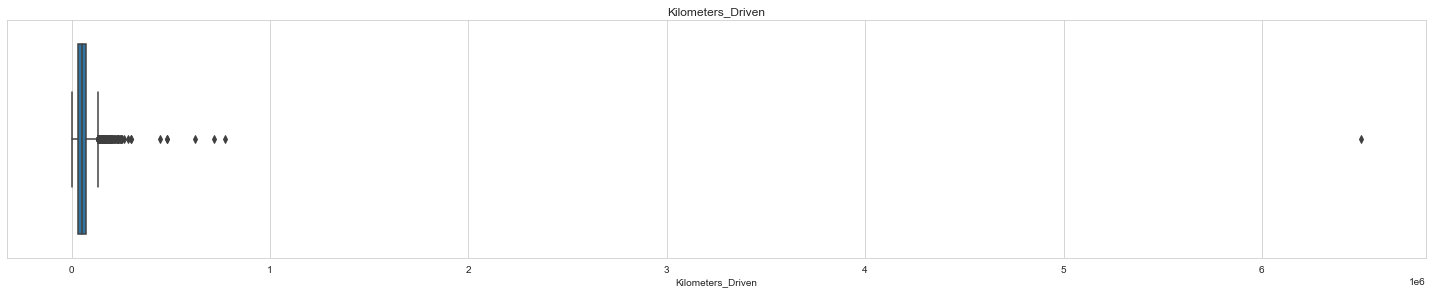

In [766]:
plt.figure(figsize=(20,4))
sns.boxplot(used_cars['Kilometers_Driven'], whis=1.5)
plt.tight_layout()
plt.title('Kilometers_Driven')

Text(0.5, 1.0, 'Price')

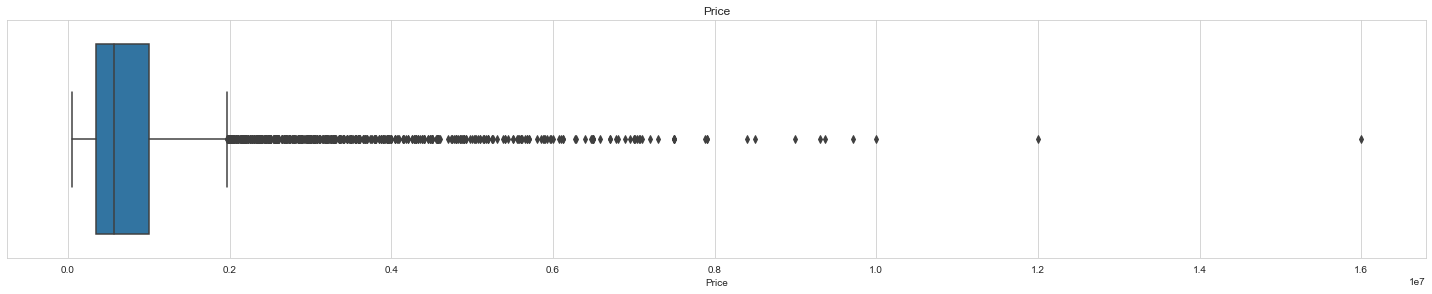

In [767]:
plt.figure(figsize=(20,4))
sns.boxplot(used_cars['Price'], whis=1.5)
plt.tight_layout()
plt.title('Price')

Text(0.5, 1.0, 'Mileage')

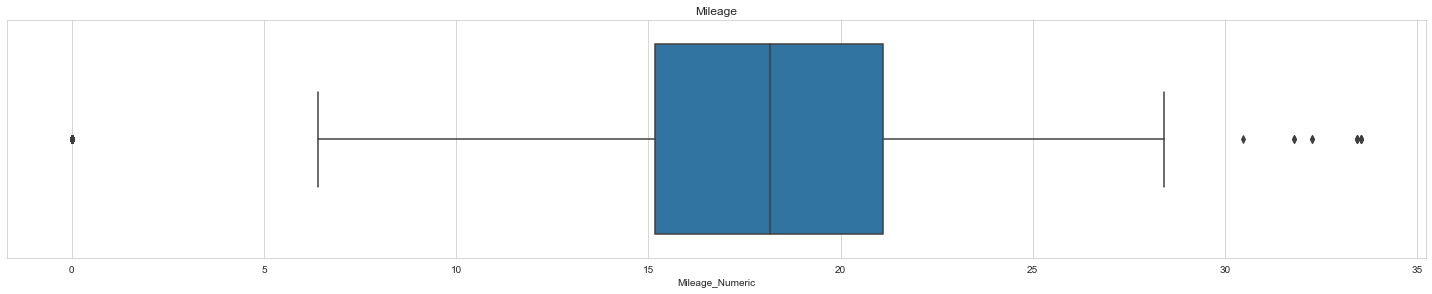

In [768]:
plt.figure(figsize=(20,4))
sns.boxplot(used_cars['Mileage_Numeric'], whis=1.5)
plt.tight_layout()
plt.title('Mileage')

Text(0.5, 1.0, 'Engine')

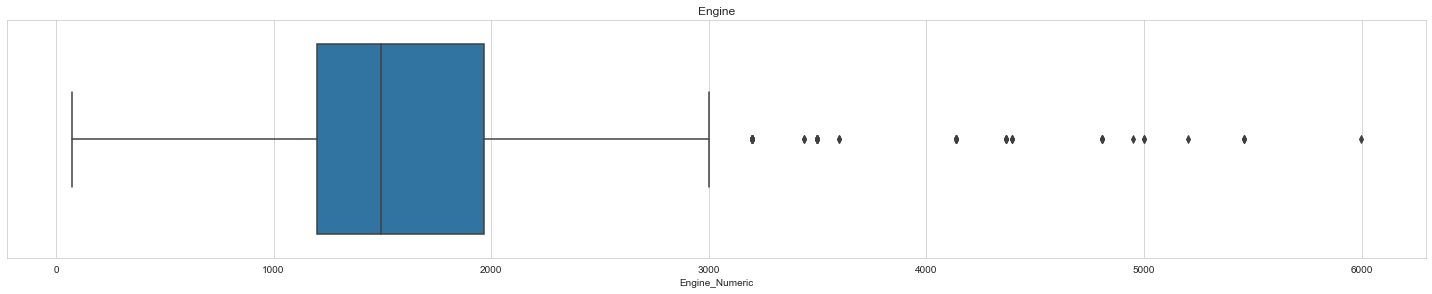

In [769]:
plt.figure(figsize=(20,4))
sns.boxplot(used_cars['Engine_Numeric'], whis=1.5)
plt.tight_layout()
plt.title('Engine')

Text(0.5, 1.0, 'Power')

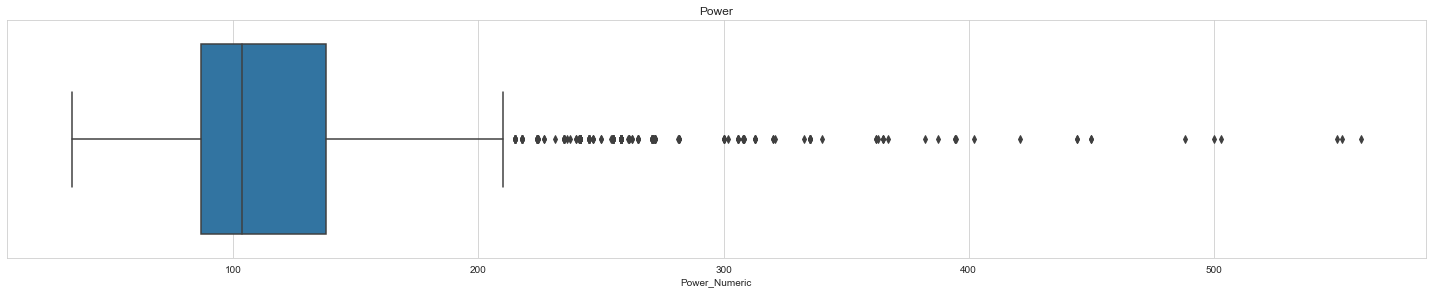

In [770]:
plt.figure(figsize=(20,4))
sns.boxplot(used_cars['Power_Numeric'], whis=1.5)
plt.tight_layout()
plt.title('Power')

Text(0.5, 1.0, 'New_Price_Numeric')

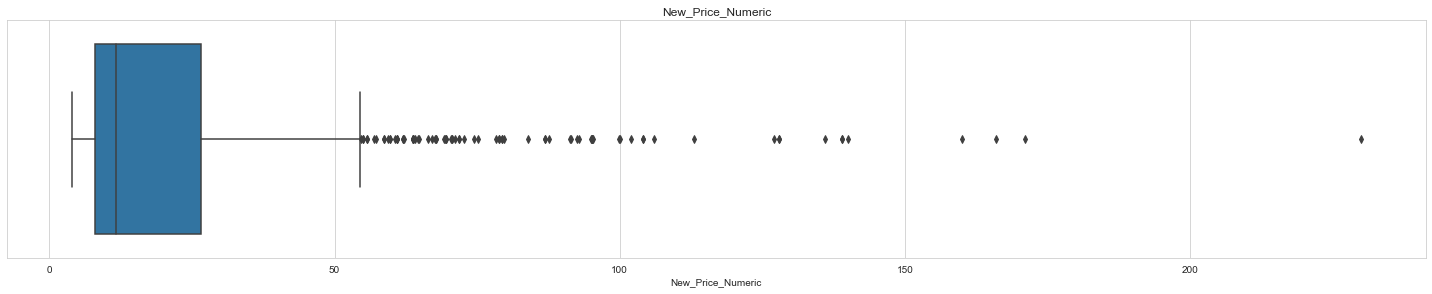

In [771]:
plt.figure(figsize=(20,4))
sns.boxplot(used_cars['New_Price_Numeric'], whis=1.5)
plt.tight_layout()
plt.title('New_Price_Numeric')

#### Boxplot Insights
1. Kilometers_Driven has one extreme value which if untreated - can potentially influence our model. It needs to be treaated. 
2. Price has quite a few outliers beyond the upper quartile and they need to be treated for outliers. 
3. Mileage has a zero value - which is not intuitive for any car. Therefore it needs to be treated as a missing value
4. Engine and Power have outliers which also need to be treated.
5. New Price has an extreme value which can influence our model and needs to be treated as well. 

### Univariate analysis of categorical vcariables

Text(0.5, 1.0, 'Fuel_Type')

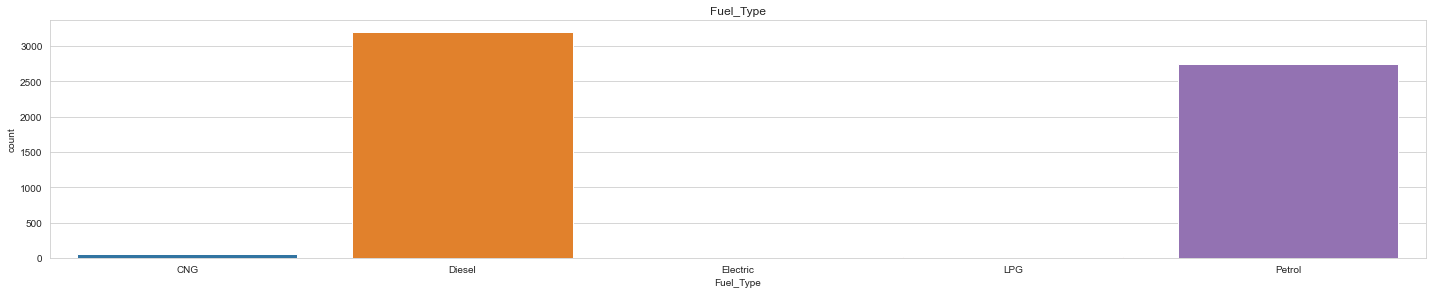

In [772]:
plt.figure(figsize=(20,4))
sns.countplot(used_cars['Fuel_Type'])
plt.tight_layout()
plt.title('Fuel_Type')

Text(0.5, 1.0, 'Owner_Type')

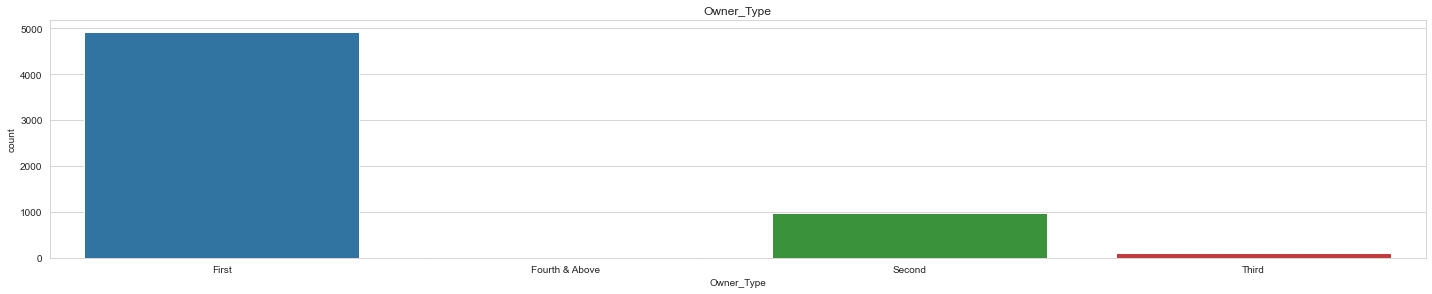

In [773]:
plt.figure(figsize=(20,4))
sns.countplot(used_cars['Owner_Type'])
plt.tight_layout()
plt.title('Owner_Type')

Text(0.5, 1.0, 'Transmission')

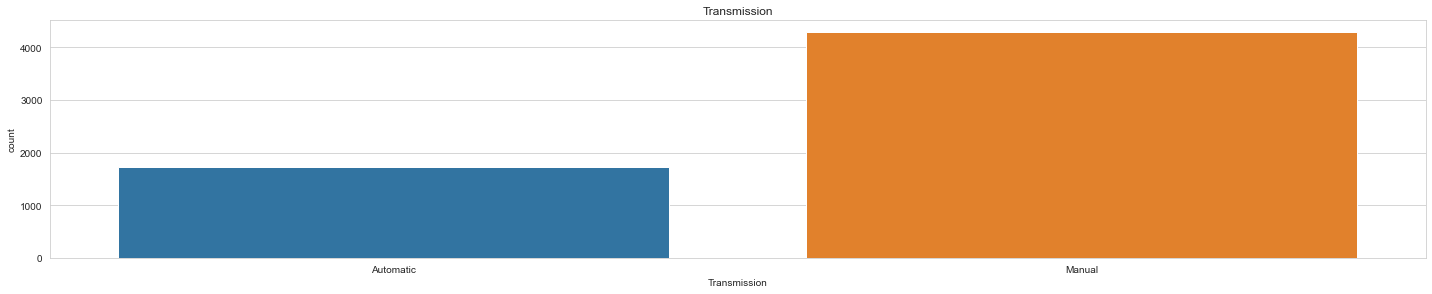

In [774]:
plt.figure(figsize=(20,4))
sns.countplot(used_cars['Transmission'])
plt.tight_layout()
plt.title('Transmission')

Text(0.5, 1.0, 'Year')

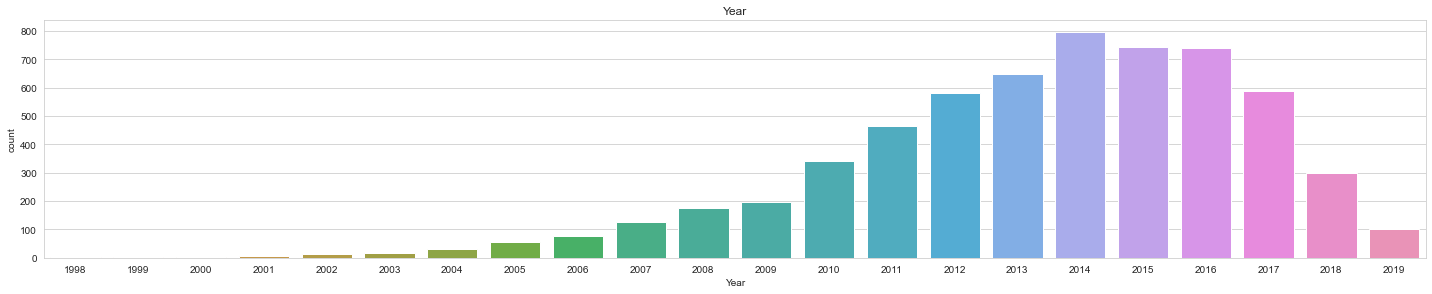

In [775]:
plt.figure(figsize=(20,4))
sns.countplot(used_cars['Year'])
plt.tight_layout()
plt.title('Year')

Text(0.5, 1.0, 'Location')

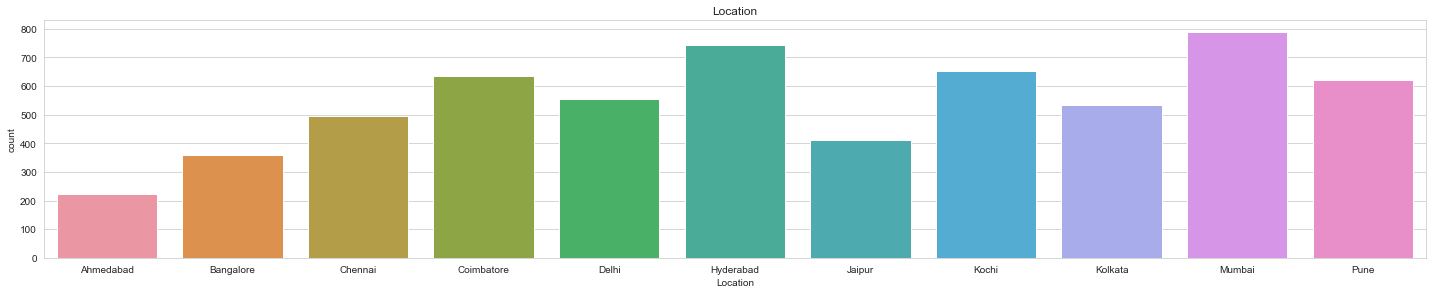

In [776]:
plt.figure(figsize=(20,4))
sns.countplot(used_cars['Location'])
plt.tight_layout()
plt.title('Location')

Text(0.5, 1.0, 'Brand')

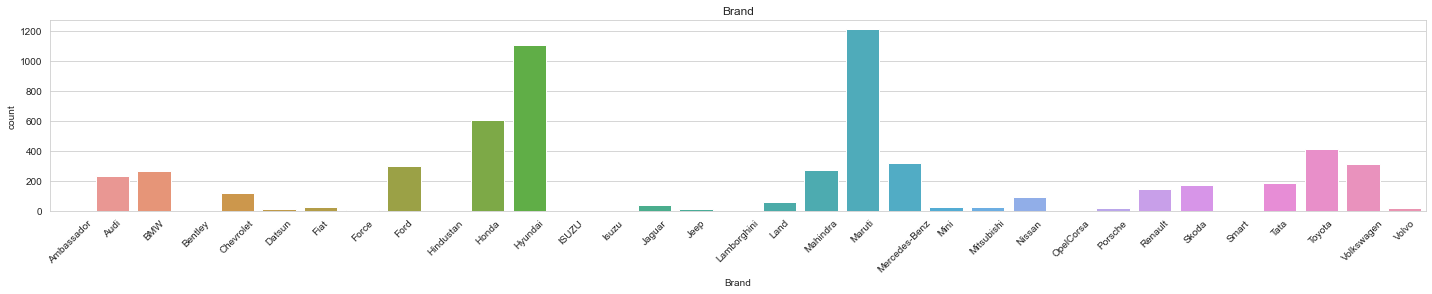

In [777]:
plt.figure(figsize=(20,4))
plt.xticks(rotation = 45)
sns.countplot(used_cars['Brand'])
plt.tight_layout()
plt.title('Brand')

#### Countplot Insights
1. Majority of cars are either Diesel or Petrol 
2. There are more manual cars than automatic
3. Majority of cars are being sold by first owners - which tells us that used car seller market is dominated by first owners 
4. Maruti, Hyundai and Honda seems to be the most popular cars in the market

### Bi-variate analysis

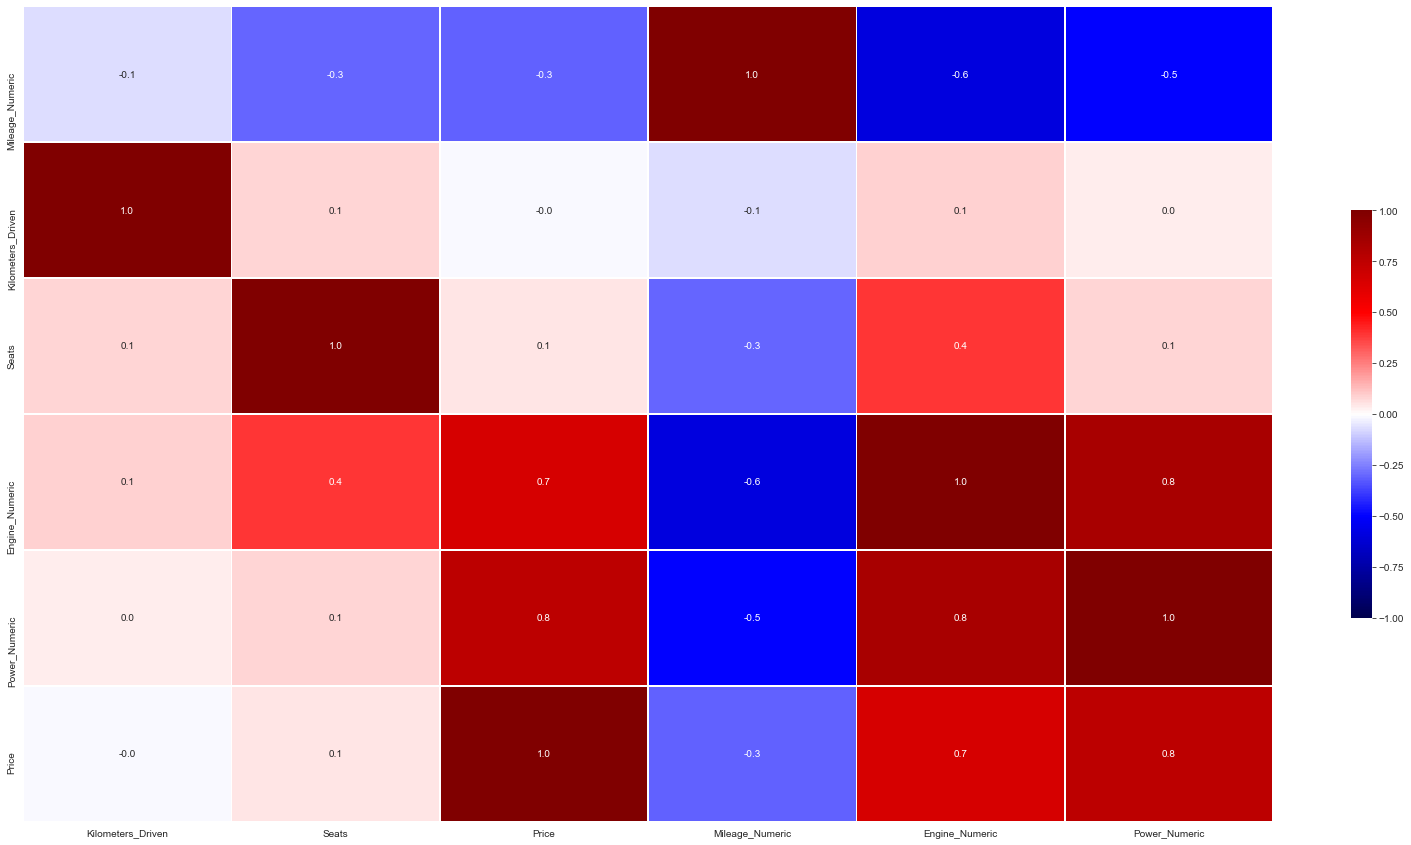

In [778]:
corr = used_cars[numerical_columns].corr().sort_values(by=['Price'])
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(28, 15))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, 
            cmap='seismic', annot=True,fmt=".1f",vmin=-1, vmax=1, center= 0,
            square=False, linewidths=.7, cbar_kws={"shrink": .5});

#### Insights:
1. Price has high positive correleation with Power (Power_Numeric) - which means prices of used cars tend to go up with higher power

2. Price has a high positive correlation with Engine capacity (Engine_Numeric)  - which means prices of used cars tend to go up with higher engine capacity. 

3. Power and Engine capacity have high correlation - which can lead to unnecessary model complexity. We expect this to be manifested in terms of high Variance Inflation Factors with values high than 5.0. We ideally want independent variables that are not correlated with each other. We will make the determination of picking or dropping variables with high VIF based on the R^2 values after regression. 

4. Price also has a high correlation with New_Price - which is not very surprising as the higher new prices may tend to fetch higher used prices in a strictly numerical sense unless we look in to % of new price fetched in the used market.   

### Lets examing variables with high correlation to prices 
Power and Engine capacity are interesting varibles to do a deeper analysis on. We can potentialyl interpose interesting categorial variable on top of this analysis to see if there is anything interesting.  

#### Price vs Power Vs Fuel_Type

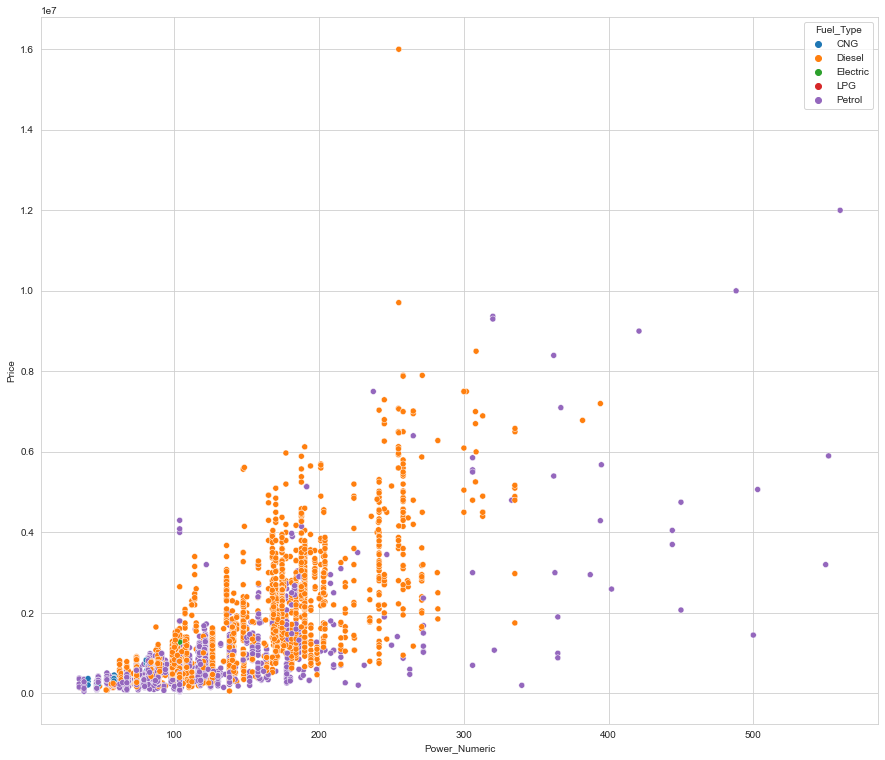

In [779]:
plt.figure(figsize=(15,13))
sns.scatterplot(y='Price', x='Power_Numeric', hue='Fuel_Type', data=used_cars);

Insight: For both Diesel and Petrol cars - Price tends to increase with Power

#### Price vs Power Vs Transmission

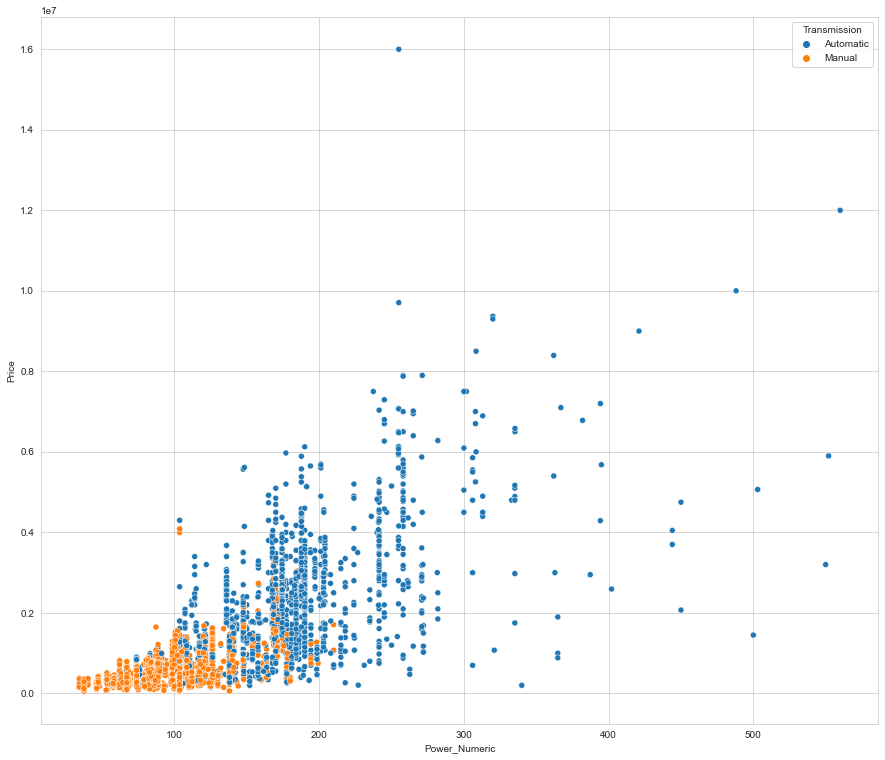

In [780]:
plt.figure(figsize=(15,13))
sns.scatterplot(y='Price', x='Power_Numeric', hue='Transmission', data=used_cars);

Insight: For both Automnatic and Manual cars - higher power tends to imply higher price

#### Price vs Engine Vs Fuel_Type

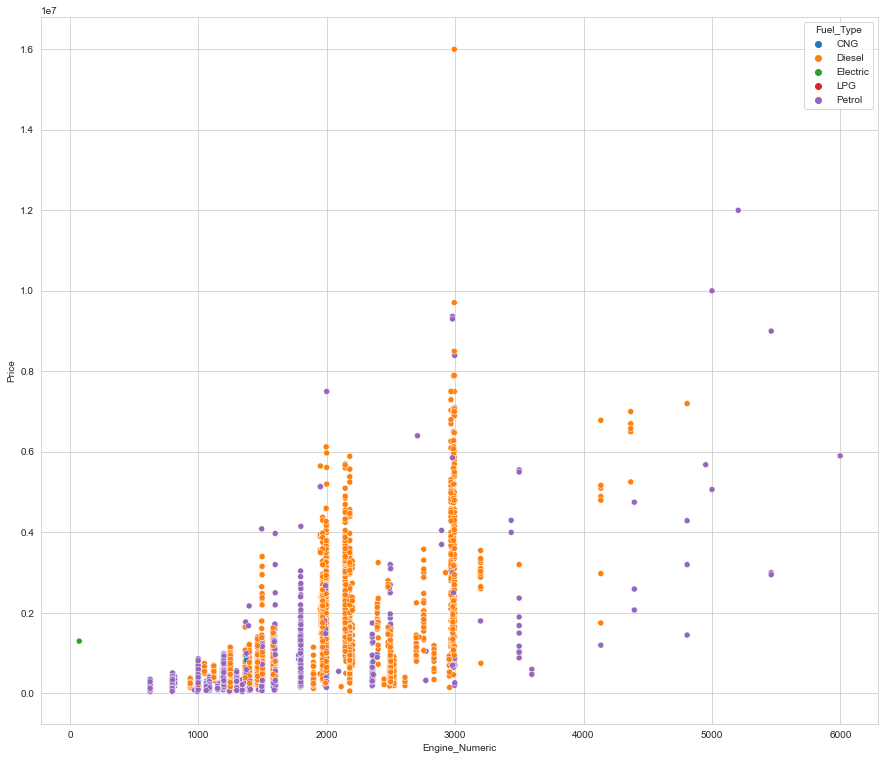

In [781]:
plt.figure(figsize=(15,13))
sns.scatterplot(y='Price', x='Engine_Numeric', hue='Fuel_Type', data=used_cars);

Insight: For both Diesel and Petrol cars, higher Engine capacity tends to imply higher prices

#### Price vs Engine Vs Transmission

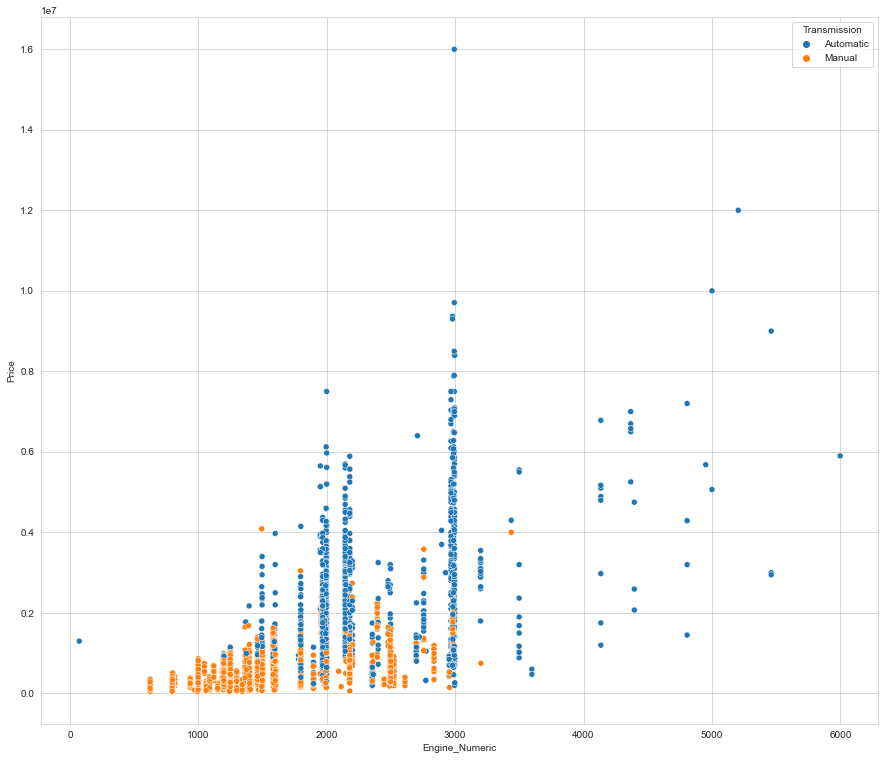

In [782]:
plt.figure(figsize=(15,13))
sns.scatterplot(y='Price', x='Engine_Numeric', hue='Transmission', data=used_cars);

#### Insight: For both Automatic and Manual cars - higher Engine capacity tends to imply higher price

#### Price vs Year 

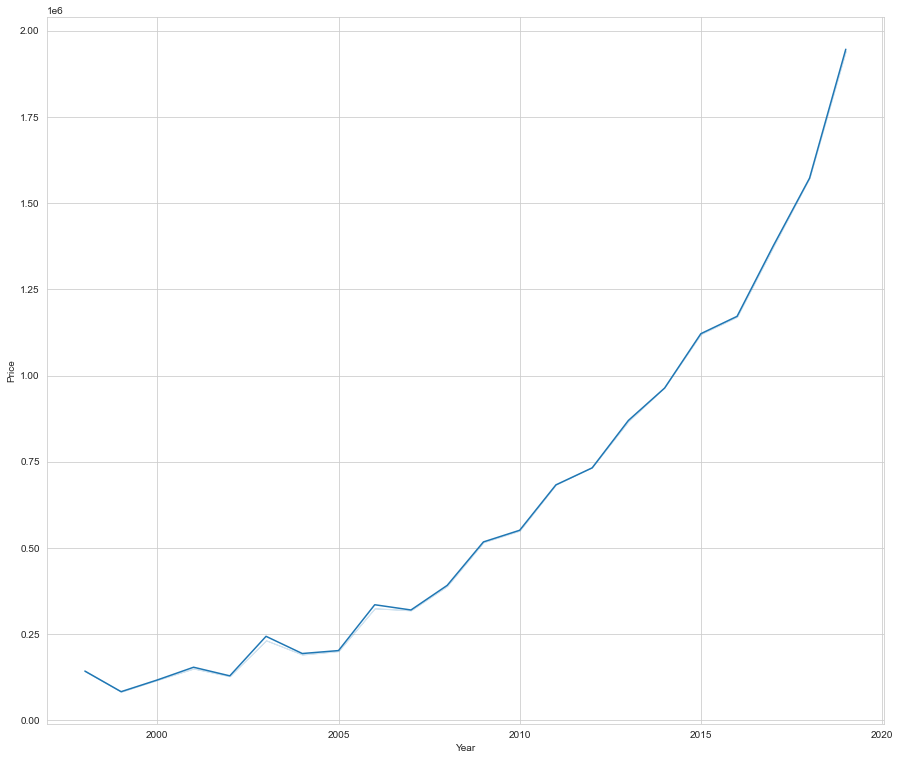

In [783]:
plt.figure(figsize=(15,13))
sns.lineplot(x='Year', y='Price', ci=0,
             data=used_cars);

#### Insight: Overall - newer cars tend to have higher prices - which shouldnt surprise us

# Data Pre-Processing

### Treat Extreme Values

In [784]:
mileage_median = used_cars['Mileage_Numeric'].median()

used_cars['Mileage_Numeric'] = np.where((used_cars.Mileage_Numeric == 0),mileage_median,used_cars.Mileage_Numeric)

### Outliers Treatment

In [785]:
# Lets treat outliers by flooring and capping
def treat_outliers(df,col):
    '''
    treats outliers in a varaible
    col: str, name of the numerical varaible
    df: data frame
    col: name of the column
    '''
    Q1=df[col].quantile(0.25) # 25th quantile
    Q3=df[col].quantile(0.75)  # 75th quantile
    IQR=Q3-Q1
    Lower_Whisker = Q1 - 1.5*IQR 
    Upper_Whisker = Q3 + 1.5*IQR
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker) # all the values samller than Lower_Whisker will be assigned value of Lower_whisker 
                                                            # and all the values above upper_whishker will be assigned value of upper_Whisker 
    return df

def treat_outliers_all(df, col_list):
    '''
    treat outlier in all numerical varaibles
    col_list: list of numerical varaibles
    df: data frame
    '''
    for c in col_list:
        df = treat_outliers(df,c)
        
    return df

In [786]:
used_cars = treat_outliers_all(used_cars,numerical_columns)

Text(0.5, 1.0, 'Kilometers_Driven')

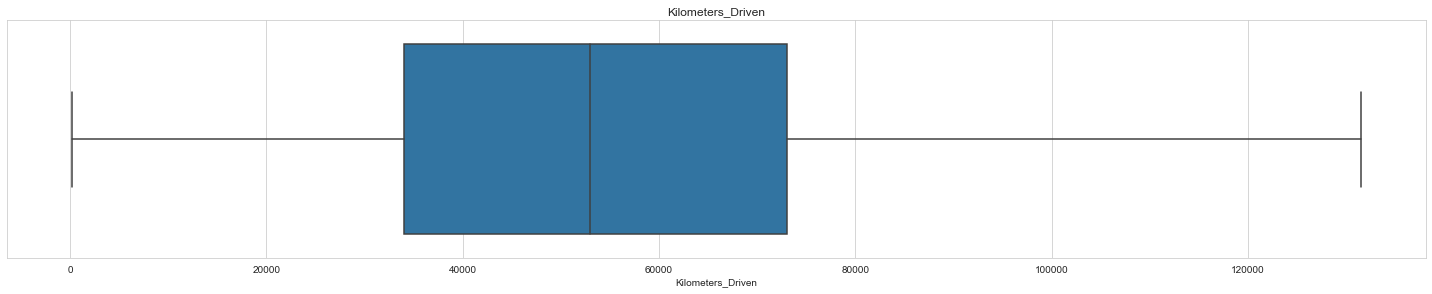

In [787]:
plt.figure(figsize=(20,4))
sns.boxplot(used_cars['Kilometers_Driven'], whis=1.5)
plt.tight_layout()
plt.title('Kilometers_Driven')

Text(0.5, 1.0, 'Price')

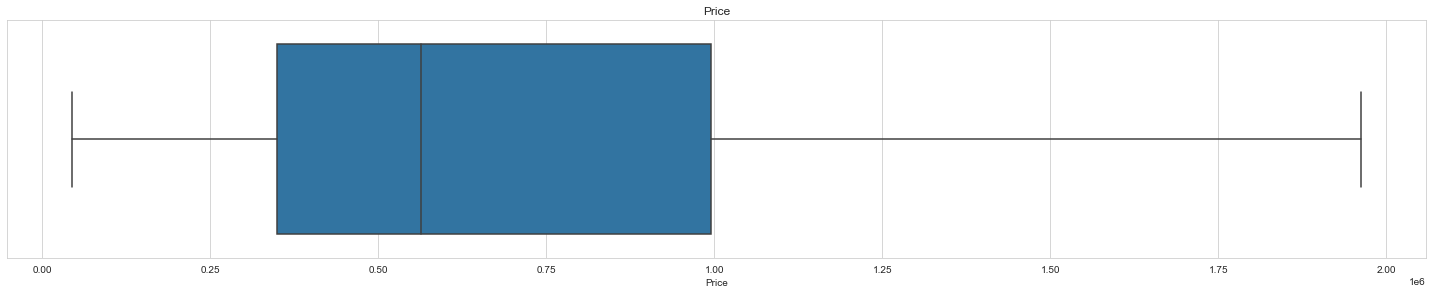

In [788]:
plt.figure(figsize=(20,4))
sns.boxplot(used_cars['Price'], whis=1.5)
plt.tight_layout()
plt.title('Price')

Text(0.5, 1.0, 'Mileage')

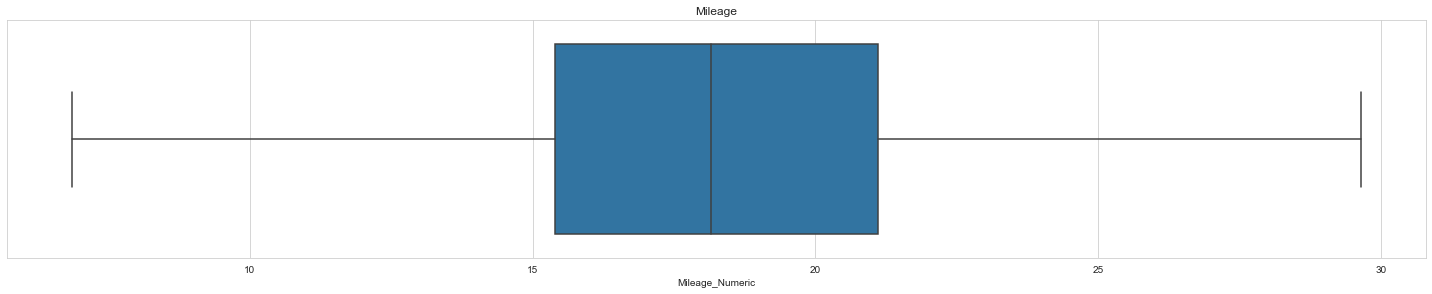

In [789]:
plt.figure(figsize=(20,4))
sns.boxplot(used_cars['Mileage_Numeric'], whis=1.5)
plt.tight_layout()
plt.title('Mileage')

Text(0.5, 1.0, 'Engine')

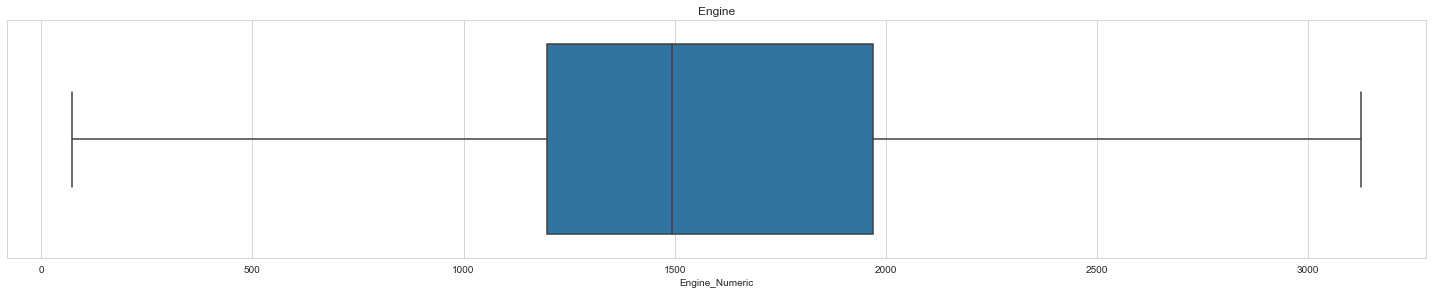

In [790]:
plt.figure(figsize=(20,4))
sns.boxplot(used_cars['Engine_Numeric'], whis=1.5)
plt.tight_layout()
plt.title('Engine')

Text(0.5, 1.0, 'Power')

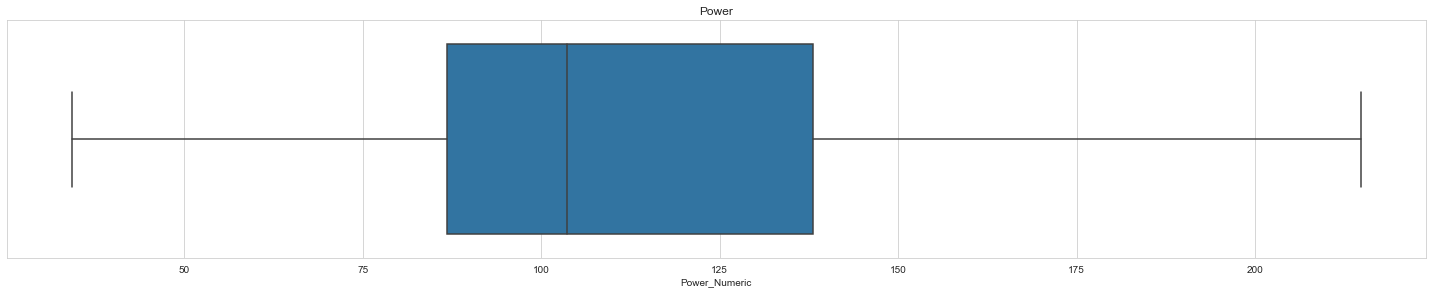

In [791]:
plt.figure(figsize=(20,4))
sns.boxplot(used_cars['Power_Numeric'], whis=1.5)
plt.tight_layout()
plt.title('Power')

Text(0.5, 1.0, 'New_Price_Numeric')

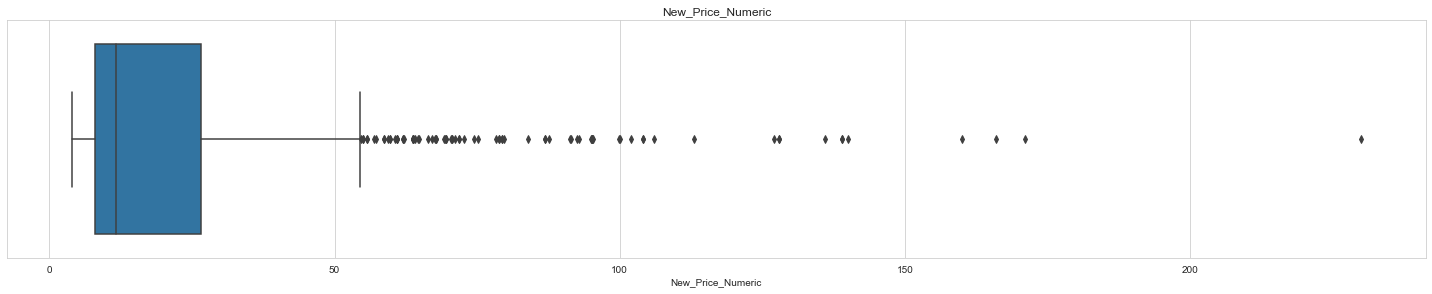

In [792]:
plt.figure(figsize=(20,4))
sns.boxplot(used_cars['New_Price_Numeric'], whis=1.5)
plt.tight_layout()
plt.title('New_Price_Numeric')

#### Obervations:
1. Outliers identified during EDA have been fixed 
2. Extreme values identified in Mileage during EDA has been fixed

## Log Transformations
As noted in our EDA - we will attempt to transform Price and Kilometers_Driven

Text(0.5, 1.0, 'log(Kilometers_Driven + 1)')

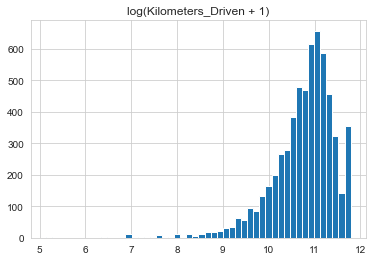

In [793]:
plt.hist(np.log(used_cars['Kilometers_Driven'] + 1), 50)
plt.title('log(Kilometers_Driven + 1)')

Text(0.5, 1.0, 'log(Price + 1)')

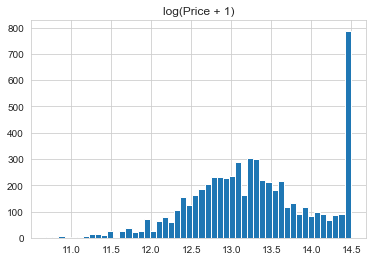

In [794]:
plt.hist(np.log(used_cars['Price'] + 1), 50)
plt.title('log(Price + 1)')

#### Observations:
Both Kilometers_Driven and Price have benefited from log transformations. The log distributions are closer to normal distribution now then they were before. There are some extreme values though. 

In [795]:
used_cars['Log_Kilometers_Driven'] = np.log( used_cars['Kilometers_Driven'] + 1)
used_cars['Log_Price'] = np.log( used_cars['Price'] + 1)

## Feature Engineering (Binning)

In [796]:
# Let's group cars under a binned category that is either deomestic or Foreign. Ambassador, Tata, Mahindra and Maruti are
# domestic brands. The rest are foreign brands
used_cars['Binned_Brand'] = used_cars['Brand']

dictionary = {
        'Maruti':'Domestic',
        'Tata':'Domestic',
        'Mahindra':'Domestic',
        'Ambassador':'Domestic',
        'Audi':'Foreign',
        'Bentley':'Foreign',
        'BMW':'Foreign',
        'Chevrolet':'Foreign',
        'Datsun':'Foreign',
        'Fiat':'Foreign',
        'Force':'Foreign',
        'Ford':'Foreign',
        'Honda':'Foreign',
        'Hyundai':'Foreign',
        'Isuzu':'Foreign',
        'ISUZU':'Foreign',
        'Jeep':'Foreign',
        'Land':'Foreign',
        'Lamborghini':'Foreign',
        'Mercedes-Benz':'Foreign',
        'Mini':'Foreign',
        'Mitsubishi':'Foreign',
        'Nissan':'Foreign',
        'Porsche':'Foreign',
        'Renault':'Foreign',
        'Skoda':'Foreign',
        'Toyota' : 'Foreign',
        'Jaguar' : 'Foreign',
        'Smart':'Foreign',
        'Volkswagen':'Foreign',
        'Volvo':'Foreign'
}

used_cars['Binned_Brand'].replace(dictionary, inplace=True)

used_cars['Binned_Brand'].unique()


array(['Domestic', 'Foreign'], dtype=object)

# Model building - Linear Regression

In [797]:
used_cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6019 entries, 0 to 6018
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   S.No.                  6019 non-null   int64   
 1   Name                   6019 non-null   object  
 2   Location               6019 non-null   category
 3   Year                   6019 non-null   int64   
 4   Kilometers_Driven      6019 non-null   int64   
 5   Fuel_Type              6019 non-null   category
 6   Transmission           6019 non-null   category
 7   Owner_Type             6019 non-null   category
 8   Mileage                6017 non-null   object  
 9   Engine                 5983 non-null   object  
 10  Power                  5983 non-null   object  
 11  Seats                  6019 non-null   float64 
 12  New_Price              824 non-null    object  
 13  Price                  6019 non-null   float64 
 14  Mileage_Numeric        6019 non-null   f

In [798]:
# Define X and y variables

X = used_cars.drop(['S.No.','Name','Kilometers_Driven','Mileage','Engine','Power','New_Price','New_Price_Numeric','Price','Log_Price','Brand'], axis=1)
y = used_cars[['Log_Price']]

In [799]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6019 entries, 0 to 6018
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Location               6019 non-null   category
 1   Year                   6019 non-null   int64   
 2   Fuel_Type              6019 non-null   category
 3   Transmission           6019 non-null   category
 4   Owner_Type             6019 non-null   category
 5   Seats                  6019 non-null   float64 
 6   Mileage_Numeric        6019 non-null   float64 
 7   Engine_Numeric         6019 non-null   float64 
 8   Power_Numeric          6019 non-null   float64 
 9   Log_Kilometers_Driven  6019 non-null   float64 
 10  Binned_Brand           6019 non-null   object  
dtypes: category(4), float64(5), int64(1), object(1)
memory usage: 560.6+ KB


In [800]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6019 entries, 0 to 6018
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Log_Price  6019 non-null   float64
dtypes: float64(1)
memory usage: 254.0 KB


In [801]:
print(X.shape)

(6019, 11)


In [802]:
print(y.shape)

(6019, 1)


In [803]:
# Let's get dummy variables for categorical variables of importance 

X = pd.get_dummies(X, columns=['Location','Transmission','Owner_Type','Fuel_Type','Binned_Brand'], drop_first=True)
print(X.shape)

(6019, 25)


In [804]:
#split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [805]:
X_train.head()

,Year,Seats,Mileage_Numeric,Engine_Numeric,Power_Numeric,Log_Kilometers_Driven,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,...,Location_Pune,Transmission_Manual,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Binned_Brand_Foreign
4201,2011,5.0,22.070000,1199.0,73.900002,11.251574,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
4383,2016,5.0,20.360001,1197.0,78.900002,9.900884,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
1779,2014,5.0,15.100000,2179.0,140.000000,11.169928,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4020,2013,5.0,25.200001,1248.0,103.599998,11.654390,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3248,2011,5.0,16.469999,1198.0,73.900002,10.981097,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1


## Choose Model, Train and Evaluate

In [806]:
lin_reg_model = LinearRegression()                                    
lin_reg_model.fit(X_train, y_train)   
LinearRegression()
coef_df = pd.DataFrame(np.append(lin_reg_model.coef_.flatten(), lin_reg_model.intercept_), \
                       index=X_train.columns.tolist()+['Intercept'], columns=['Coefficients'])
print(coef_df)

                           Coefficients
Year                       1.098326e-01
Seats                      7.483163e-16
Mileage_Numeric           -4.403687e-03
Engine_Numeric             3.709495e-04
Power_Numeric              5.128219e-03
Log_Kilometers_Driven     -3.766230e-02
Location_Bangalore         1.014084e-01
Location_Chennai          -5.761709e-02
Location_Coimbatore        1.397646e-02
Location_Delhi            -8.698001e-02
Location_Hyderabad         4.124086e-02
Location_Jaipur           -1.369416e-01
Location_Kochi            -5.795982e-02
Location_Kolkata          -2.516399e-01
Location_Mumbai           -4.480406e-02
Location_Pune             -9.918860e-02
Transmission_Manual       -2.575269e-01
Owner_Type_Fourth & Above -6.239045e-02
Owner_Type_Second         -6.260534e-02
Owner_Type_Third          -2.108548e-01
Fuel_Type_Diesel           1.366760e-01
Fuel_Type_Electric         1.056693e+00
Fuel_Type_LPG             -3.615392e-02
Fuel_Type_Petrol          -6.950524e-02


In [807]:
# MAPE
def mape(targets, predictions):
    return np.mean(np.abs((targets - predictions)) / targets) * 100

# Adjusted R^2
def adj_r2(ind_vars, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = ind_vars.shape[0]
    k = ind_vars.shape[1]
    return 1-((1-r2)*(n-1)/(n-k-1))

# Model performance check
def model_perf(model, inp, out):

    y_pred = model.predict(inp)
    y_act = out.values

    return pd.DataFrame({
                "RMSE": np.sqrt(mean_squared_error(y_act, y_pred)),
                "MAE": mean_absolute_error(y_act, y_pred),
                "MAPE": mape(y_act, y_pred),
                "R^2": r2_score(y_act, y_pred),
                "Adjusted R^2": adj_r2(inp, y_act, y_pred)
           }, index=[0])

In [808]:
print('Training Performance\n')
print(model_perf(lin_reg_model, X_train, y_train))

Training Performance

       RMSE       MAE      MAPE       R^2  Adjusted R^2
0  0.292387  0.222258  1.679163  0.850778      0.849887


In [809]:
# Checking model performance on test set
print('Test Performance\n')
print(model_perf(lin_reg_model, X_test, y_test))

Test Performance

       RMSE       MAE      MAPE      R^2  Adjusted R^2
0  0.300748  0.228664  1.735488  0.84911      0.846991


## Conclusion
1. The training and test RMSE are 0.29 & 0.3 respectively and both scores are very comparable. Hence the model is a good fit. 
2. R^2 value is almost 0.85 which means the model is able to explain 85% of all variance

# Checking the Linear Regression Assumptions
1. No Multicollinearity
2. Mean of residuals should be 0
3. Linearity of variables
4. HOMOSCEDASTICITY
5. Normality of error terms

## 1. Test for multicollinearity
Multicolinearity occurs when independent variables have high correlation. High multicollinearity between independent variabels can cause model complexity and fitting issues. Variance Inflation Factor (VIF) is a measure of variances in regression due to existance of colliniearity. VIF close to 1 is desirable. 

In [810]:
# to compute VIF, we first have to add a constant column having value 1 to our input variables

X1 = X.copy()
X1['const'] = 1
X1.head()

,Year,Seats,Mileage_Numeric,Engine_Numeric,Power_Numeric,Log_Kilometers_Driven,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,...,Transmission_Manual,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Binned_Brand_Foreign,const
0,2010,5.0,26.600000,998.0,58.160000,11.184435,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,2015,5.0,19.670000,1582.0,126.199997,10.621352,0,0,0,0,...,1,0,0,0,1,0,0,0,1,1
2,2011,5.0,18.200001,1199.0,88.699997,10.736418,0,1,0,0,...,1,0,0,0,0,0,0,1,1,1
3,2012,5.0,20.770000,1248.0,88.760002,11.373675,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
4,2013,5.0,15.200000,1968.0,140.800003,10.613271,0,0,1,0,...,0,0,1,0,1,0,0,0,1,1


In [811]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_series1 = pd.Series([variance_inflation_factor(X1.values,i) for i in range(X1.shape[1])],index=X1.columns)
print('VIF Series before feature selection: \n\n{}\n'.format(vif_series1))

VIF Series before feature selection: 

Year                          1.996644
Seats                         0.000000
Mileage_Numeric               3.204220
Engine_Numeric                5.661335
Power_Numeric                 4.373213
Log_Kilometers_Driven         1.698202
Location_Bangalore            2.472777
Location_Chennai              2.979438
Location_Coimbatore           3.518549
Location_Delhi                3.166240
Location_Hyderabad            3.807343
Location_Jaipur               2.671417
Location_Kochi                3.572875
Location_Kolkata              3.135923
Location_Mumbai               4.004603
Location_Pune                 3.424729
Transmission_Manual           1.898611
Owner_Type_Fourth & Above     1.012280
Owner_Type_Second             1.169222
Owner_Type_Third              1.107854
Fuel_Type_Diesel             28.548061
Fuel_Type_Electric            1.043076
Fuel_Type_LPG                 1.195092
Fuel_Type_Petrol             29.272946
Binned_Brand_Foreign     

#### Observations
1. Fuel_Type_Diesel & Fuel_Type_Petrol have a very high VIF. Clearly these variables are highly correlated. It was also evident when we did the EDA that nearly half of the vehicles were Diesel and the other hald Petrol. 
2. Engine and Power have high collinearity - which again is not surprising - as this is what we noticed in the correlation tests performed during EDA. 
3. Our next action is to remove one column at a time and re-run VIF to a point where all VIFs are below 5

In [812]:
# Method to drop all the multicollinear columns and choose which one we should drop
def treating_multicollinearity(high_vif_columns, x_train, x_test, y_train, y_test):
    """
    Drop every column that has VIF score greater than 5, one by one.
    Look at the adjusted R square of all these models
    Look at the RMSE of all these models on test data
    """
    adj_rsq_scores = []
    rmse_test_data = []

    # build ols models by dropping one of these at a time and observe the Adjusted R-squared
    for cols in high_vif_columns:
        train = x_train.loc[:, ~x_train.columns.str.startswith(cols)]
        test = x_test.loc[:, ~x_test.columns.str.startswith(cols)]
        # Create the model
        
        model = LinearRegression(fit_intercept=False)
        model.fit(train, y_train)
        # Adj R-Sq
        adj_rsq_scores.append(adj_r2(train, y_train, model.predict(train)))
        # RMSE (Test data)
        y_pred_test_Price = model.predict(test)
        y_test_Price = y_test
        rmse_test_data.append(np.sqrt(mean_squared_error(y_pred_test_Price, y_test_Price)))

    # Add new Adj_Rsq and RMSE after dropping each colmn
    temp = pd.DataFrame(
        {
            "col": high_vif_columns,
            "Adj_rsq_after_dropping_col": adj_rsq_scores,
            "Test RMSE": rmse_test_data,
        }
    ).sort_values(by="Adj_rsq_after_dropping_col", ascending=False)

    print(temp)

In [813]:
# Let's find out the impact on the RMSE & R^2 after dropping the identified columns with high VIF
high_vif_columns = ["Engine_Numeric","Fuel_Type_Diesel","Fuel_Type_Petrol" ]

X_train1 = X_train.copy()
X_train1['constant'] = 1

X_test1 = X_test.copy()
X_test1['constant'] = 1

treating_multicollinearity(high_vif_columns, X_train1, X_test1, y_train, y_test)

                col  Adj_rsq_after_dropping_col  Test RMSE
2  Fuel_Type_Petrol                    0.849816   0.300777
1  Fuel_Type_Diesel                    0.849603   0.301114
0    Engine_Numeric                    0.836358   0.313179


#### Observation
1. It is clear that dropping Fuel types only moderately increases R^2
2. Whereas dropping Engine drops R^2 to 0.836358 - which is almost a 2% drop in R^2. 

In [814]:
# Let's drop Fuel_Type_Diesel and check for VIF again
X_train2 = X_train1.drop('Fuel_Type_Diesel', axis=1)
vif_series2 = pd.Series([variance_inflation_factor(X_train2.values,i) for i in range(X_train2.shape[1])],index=X_train2.columns)
print('Series before feature selection: \n\n{}\n'.format(vif_series2))

Series before feature selection: 

Year                         1.982030
Seats                        0.000000
Mileage_Numeric              3.323277
Engine_Numeric               5.825118
Power_Numeric                4.372244
Log_Kilometers_Driven        1.698399
Location_Bangalore           2.582001
Location_Chennai             2.988466
Location_Coimbatore          3.584946
Location_Delhi               3.244216
Location_Hyderabad           3.875513
Location_Jaipur              2.677772
Location_Kochi               3.653321
Location_Kolkata             3.200528
Location_Mumbai              4.049580
Location_Pune                3.508925
Transmission_Manual          1.903382
Owner_Type_Fourth & Above    1.009304
Owner_Type_Second            1.165819
Owner_Type_Third             1.115304
Fuel_Type_Electric           1.017834
Fuel_Type_LPG                1.025121
Fuel_Type_Petrol             2.379642
Binned_Brand_Foreign         1.174057
constant                     0.000000
dtype: float64


In [815]:
# Let's check for model performance after dropping Fuel_Type_Diesel
lin_reg_model1 = LinearRegression(fit_intercept=False)
lin_reg_model1.fit(X_train2,y_train)

print('Training Performance\n')
print(model_perf(lin_reg_model1, X_train2, y_train))

Training Performance

       RMSE       MAE      MAPE       R^2  Adjusted R^2
0  0.292664  0.222527  1.681196  0.850496      0.849603


#### Observation
1. Dropping Fuel_Type_Diesel solves the collinearity issue between Diesel and Petrol fuel types. 

In [816]:
# We'll drop Engine_Numeric and check for VIF again

X_train3 = X_train2.drop('Engine_Numeric', axis=1)
vif_series2 = pd.Series([variance_inflation_factor(X_train3.values,i) for i in range(X_train3.shape[1])],index=X_train3.columns)
print('Series before feature selection: \n\n{}\n'.format(vif_series2))

Series before feature selection: 

Year                         1.970018
Seats                        0.000000
Mileage_Numeric              2.062822
Power_Numeric                3.211409
Log_Kilometers_Driven        1.697635
Location_Bangalore           2.581952
Location_Chennai             2.988010
Location_Coimbatore          3.584860
Location_Delhi               3.242993
Location_Hyderabad           3.875513
Location_Jaipur              2.677713
Location_Kochi               3.653261
Location_Kolkata             3.200454
Location_Mumbai              4.047990
Location_Pune                3.508735
Transmission_Manual          1.902474
Owner_Type_Fourth & Above    1.009181
Owner_Type_Second            1.165671
Owner_Type_Third             1.115289
Fuel_Type_Electric           1.005873
Fuel_Type_LPG                1.019828
Fuel_Type_Petrol             1.673627
Binned_Brand_Foreign         1.173461
constant                     0.000000
dtype: float64



In [817]:
# Let's check for model performance after dropping Engine_Numeric

In [818]:
lin_reg_model1 = LinearRegression(fit_intercept=False)
lin_reg_model1.fit(X_train3,y_train)

print('Training Performance\n')
print(model_perf(lin_reg_model1, X_train3, y_train))

Training Performance

      RMSE       MAE      MAPE       R^2  Adjusted R^2
0  0.30558  0.232399  1.760288  0.837009      0.836075


#### Observation
1. Dropping Engine_Numeric solves the collinearity issue between Engine & Power. 
2. At the sametime - regression R^2 drops by 2% points to 0.830973

### Model to keep

In [819]:
lin_reg_model1 = LinearRegression(fit_intercept=False)
lin_reg_model1.fit(X_train2,y_train)

print('Training Performance\n')
print(model_perf(lin_reg_model1, X_train2, y_train))

Training Performance

       RMSE       MAE      MAPE       R^2  Adjusted R^2
0  0.292664  0.222527  1.681196  0.850496      0.849603


### Observations 
1. Original model R^2 before treating for VIF was 0.846991 with a RMSE of 0.300748 
2. After eliminating the VIF from Fuel typoe - R^2 changed to 0.849603 with a RMSE of 0.292664. In this model, there is still a moderately high VIF of 5.8 between Engine and Power. 
3. After eliminating the VIF between Engine and Power - R^2 dropped to 0.836075. But all VIFs were solved. But the elimination of VIF between engine and power results in model perfromance deterioration of almost 2%. Since Engine and Power are very relevant features, we are proposing to keep both these variables in the model to accommdoate any future changes. 

Therefore - our preferred model is Model 2 resulting from dropping Fuel_Type_Diesel

## 2. Mean of residuals should be 0

In [820]:
# predicted values
fitted = lin_reg_model1.predict(X_train2)
residual = fitted - y_train.values

np.mean(residual)

-1.9748982152658657e-11

Mean of redisuals is very close to 0.

## 3. Linearity of variables

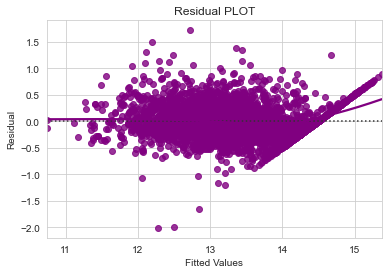

In [821]:
sns.set_style("whitegrid")
sns.residplot(fitted,residual,color="purple",lowess=True)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Residual PLOT")
plt.show()

There is no discernable patter in residuals. Therefore our assumption of linearity of varaibles is good

## 4. HOMOSCEDASTICITY


Homoscedacity is evident when residuals are symmetrically distributed across regression line. 
Heteroscedacity is when variance is unequal across the regression line. 
There is no pattern evident in this residual plot and hence the variance of residuals can be told to be unequal and hence there is no HOMOSCEDASTICITY

## 5. Normality


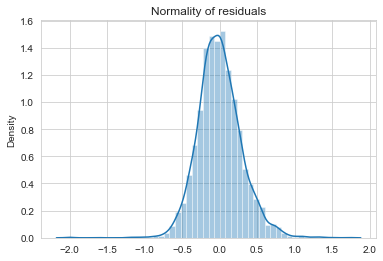

In [822]:
sns.distplot(residual)
plt.title('Normality of residuals')
plt.show()

A plot of residuals reveals that they are very normal in distribution.

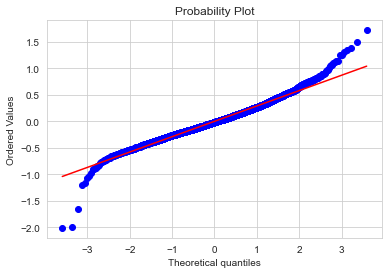

In [823]:
import pylab
import scipy.stats as stats
stats.probplot(residual.flatten(),dist="norm",plot=pylab)
plt.show()

The QQ plot of residuals confirms our normality assumption 

# Predicting test data

In [824]:
X_train2.columns

Index(['Year', 'Seats', 'Mileage_Numeric', 'Engine_Numeric', 'Power_Numeric',
       'Log_Kilometers_Driven', 'Location_Bangalore', 'Location_Chennai',
       'Location_Coimbatore', 'Location_Delhi', 'Location_Hyderabad',
       'Location_Jaipur', 'Location_Kochi', 'Location_Kolkata',
       'Location_Mumbai', 'Location_Pune', 'Transmission_Manual',
       'Owner_Type_Fourth & Above', 'Owner_Type_Second', 'Owner_Type_Third',
       'Fuel_Type_Electric', 'Fuel_Type_LPG', 'Fuel_Type_Petrol',
       'Binned_Brand_Foreign', 'constant'],
      dtype='object')

In [825]:
# first we add the constant to test input variables
X_test['constant'] = 1

X_test_final = X_test[X_train2.columns]

In [826]:
X_test_final.head()

,Year,Seats,Mileage_Numeric,Engine_Numeric,Power_Numeric,Log_Kilometers_Driven,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,...,Location_Pune,Transmission_Manual,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Binned_Brand_Foreign,constant
2868,2013,5.0,23.40,1248.0,103.599998,11.141876,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
5924,2017,5.0,15.40,1997.0,120.000000,10.193991,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3764,2014,5.0,15.10,2179.0,140.000000,11.362114,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
4144,2016,5.0,25.00,1396.0,69.010002,10.859018,0,0,0,0,...,1,1,0,1,0,0,0,0,0,1
2780,2009,5.0,18.16,1493.0,103.599998,11.512935,0,0,0,0,...,1,1,0,0,0,0,0,1,1,1


In [827]:
y_pred = lin_reg_model1.predict(X_test_final)

#### Checking the performance on train and test

In [828]:
print('Training Performance\n')
print(model_perf(lin_reg_model1, X_train2, y_train))

Training Performance

       RMSE       MAE      MAPE       R^2  Adjusted R^2
0  0.292664  0.222527  1.681196  0.850496      0.849603


In [829]:
print('Test Performance\n')
print(model_perf(lin_reg_model1, X_test_final, y_test))

Test Performance

       RMSE       MAE      MAPE       R^2  Adjusted R^2
0  0.301114  0.228825  1.736567  0.848743      0.846618


Observations:
1. Both test and train errors are low and the RMSEs are also comparable. 
2. Hence lin_reg_model1 is good for prediction as well as inference

In [830]:
lin_reg_model1 = LinearRegression(fit_intercept=False)
lin_reg_model1.fit(X_train2,y_train)

# let us check the coefficients and intercept of the model

coef_df = pd.DataFrame(lin_reg_model1.coef_.flatten(), \
                       index=X_train2.columns.tolist(), columns=['Coefficients'])
print(coef_df)

# model performance
print('\n\nTraining Performance\n')
print(model_perf(lin_reg_model1, X_train2, y_train))

                           Coefficients
Year                           0.110015
Seats                        -40.125197
Mileage_Numeric               -0.004678
Engine_Numeric                 0.000371
Power_Numeric                  0.005153
Log_Kilometers_Driven         -0.037581
Location_Bangalore             0.102860
Location_Chennai              -0.055449
Location_Coimbatore            0.015318
Location_Delhi                -0.087297
Location_Hyderabad             0.043547
Location_Jaipur               -0.133974
Location_Kochi                -0.058263
Location_Kolkata              -0.249397
Location_Mumbai               -0.046406
Location_Pune                 -0.100007
Transmission_Manual           -0.256550
Owner_Type_Fourth & Above     -0.060929
Owner_Type_Second             -0.062807
Owner_Type_Third              -0.212051
Fuel_Type_Electric             0.924650
Fuel_Type_LPG                 -0.168208
Fuel_Type_Petrol              -0.202779
Binned_Brand_Foreign           0.100760


# Conclusion & Insights

1. Impact of model year - Used cars of newer years fetch better prices in the used market. 
2. Used cars of the same model seem sell for more in the following cities - Bangalore, Coimbatore & Hyderabad. 
3. Manual transmission cars seem to fetch lower prices compared to automatic cars
4. Electric cars seem to demand a premium compared to their petroleum counterparts
5. Import cars seem to demand a premium compared to domestic cars. 

Strategies for profit maximization: 
1. Cars4U should focus on selling more cars with higher power and engine capacity since this clearly means a higher selling price for the company. 
2. Cars4U should also start to focus on selling more electric cars these 
3. Cars4U should start thinking about regional strategies toi maximize profits by focussing more on selling in Bangalore, Coimbatiore and Hyderabad. 
4. Cars4U should also start thinking about increasing the share of foreign made cars - as these tend to fetch more in used market. 